![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)


# Download SWOT from AVISO
This notebook explains how to explore and retrieve available SWOT LR data from AVISO's THREDDS Data Server and FTP Server, presented [here](https://www.aviso.altimetry.fr/en/missions/current-missions/swot/access-to-data.html).

L2 data can be explored at: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/L2/L2-SWOT-DATA/L2-SWOT.html

L3 data can be explored at: https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html

## Tutorial Objectives
* Discover ODATIS's Thredds Data Server catalogue
* Download files through HTTP and FTP
* Download a dataset through Opendap

## Import + code



In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import re
from getpass import getpass
from urllib.parse import urlparse
import numpy as np
import requests as rq
import ftplib
import xarray as xr
from xarray.backends import PydapDataStore

In [3]:
def _get_filename_from_cd(cd):
    """ Get filename from content-disposition """
    if not cd:
        return None
    fname = re.findall('filename="(.+)"', cd)
    if len(fname) == 0:
        return None
    return fname[0]

def http_download_file(dataset_url:str, output_path:str):
    response = rq.get(dataset_url, auth=(username, password))

    try:
        response.raise_for_status()
    except rq.exceptions.HTTPError as err:
        raise Exception(err)
        
    filename = os.path.basename(urlparse(dataset_url).path)
    file_path = os.path.join(output_path, filename)
    
    open(file_path, 'wb').write(response.content)
    return file_path

def _download_file(ftp:str, filename:str, target_directory:str):
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            print(f"Downloaded {filename} to {target_directory}")
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        
def ftp_download_file(ftp_path:str, filename:str, output_path:str):
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    try:
        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")

            # Check if the file exists in the directory
            if filename in ftp.nlst():
                return _download_file(ftp, filename, output_path)
            else:
                print(f"File {filename} does not exist in the directory {ftp_path}.")
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")
    
def open_dataset(dataset_url):
    """ Open the dataset at dataset_url.
    Args:
        dataset_url

    Returns:
        xr.Dataset
    """
    session = rq.Session()
    session.auth = (username, password)
    try:
        store = PydapDataStore.open(dataset_url, session=session, timeout=300, user_charset='UTF-8')
        return xr.open_dataset(store)
    except Exception as e:
        print(f"Something wrong with opendap url {dataset_url}: {e}")

## Parameters
Define **existing** output folder to save results



In [4]:
output_dir = "downloads"

### Authentication parameters
Enter your AVISO+ credentials



In [5]:
username = input("Enter username:")

Enter username: aviso-swot@altimetry.fr


In [6]:
password = getpass(f"Enter password for {username}:")

Enter password for aviso-swot@altimetry.fr: ········


## Download files through HTTP
To find the data you want to download, you can explore the [Swot LR L2](https://tds-odatis.aviso.altimetry.fr/thredds/catalog/L2/L2-SWOT-DATA/L2-SWOT.html) or [Swot LR L3](https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html) catalogues.

Copy the **FileServer** url to download data through HTTP : 
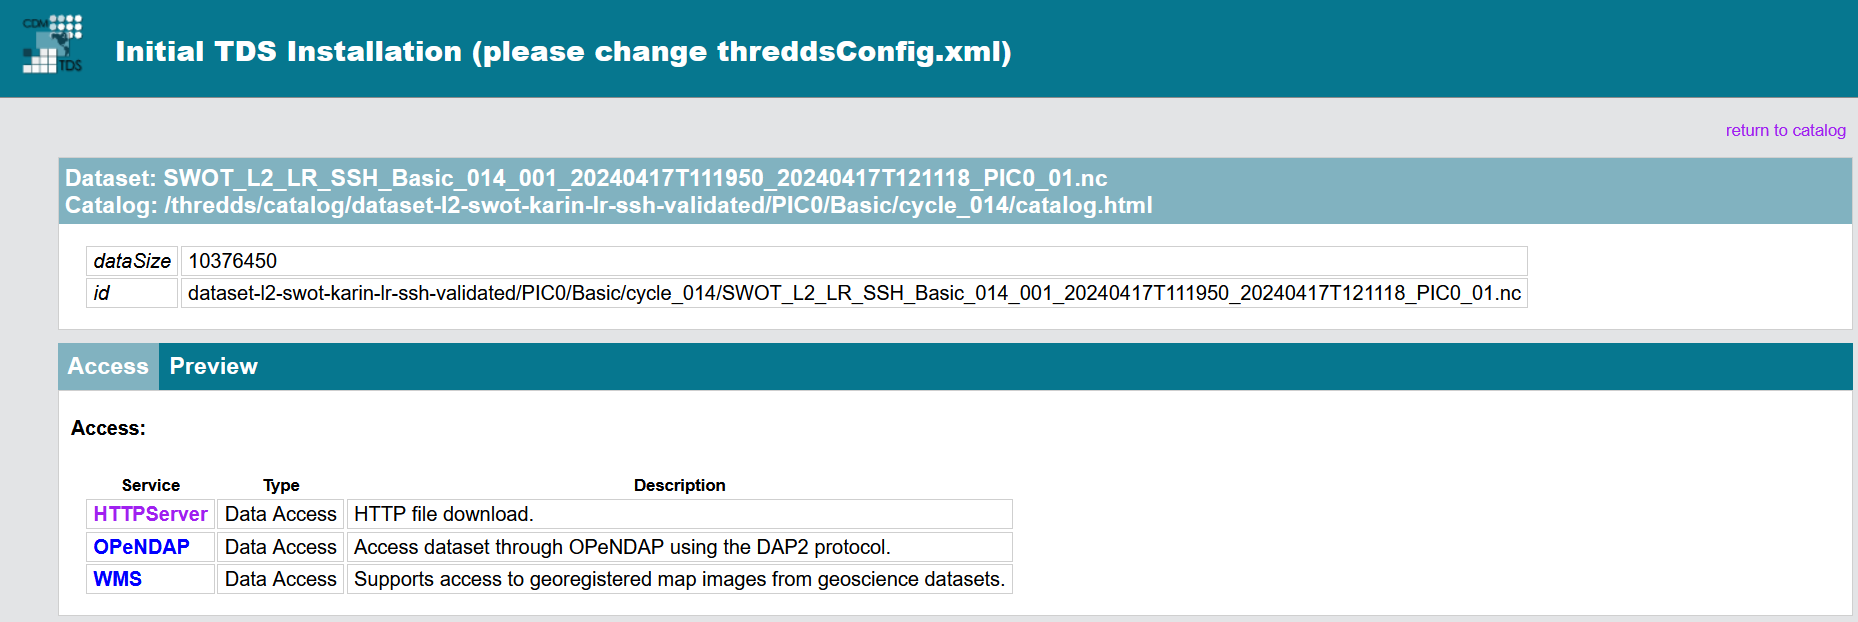

In [7]:
swot_lr_dataset_url = "https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l2-swot-karin-lr-ssh-validated/PIC0/Basic/cycle_014/SWOT_L2_LR_SSH_Basic_014_001_20240417T111950_20240417T121118_PIC0_01.nc"

In [8]:
swot_lr_file = http_download_file(swot_lr_dataset_url, output_dir)
swot_lr_file

'downloads/SWOT_L2_LR_SSH_Basic_014_001_20240417T111950_20240417T121118_PIC0_01.nc'

## Download files through FTP
Files available through FTP follow the same file tree as in the THREDDS Data Server.

| Data | FTP starting point | Browsing files URL |
| --- | --- | --- |
| Swot LR L2 | */swot_products/l2_karin/l2_lr_ssh* | https://tds-odatis.aviso.altimetry.fr/thredds/catalog/L2/L2-SWOT-DATA/L2-SWOT.html |
| Swot LR L3 | */swot_products/l3_karin_nadir/l3_lr_ssh* | https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html |

In [9]:
ftp_path = '/swot_products/l2_karin/l2_lr_ssh/PIC0/Expert/cycle_008/'
ftp_file = 'SWOT_L2_LR_SSH_Expert_008_001_20231214T064919_20231214T074047_PIC0_01.nc'

In [10]:
swot_lr_file = ftp_download_file(ftp_path, ftp_file, output_dir)
swot_lr_file

Connection Established 220 192.168.10.119 FTP server ready
Downloaded SWOT_L2_LR_SSH_Expert_008_001_20231214T064919_20231214T074047_PIC0_01.nc to downloads


'downloads/SWOT_L2_LR_SSH_Expert_008_001_20231214T064919_20231214T074047_PIC0_01.nc'

## Load a dataset via OPeNDAP
To find the data you want to load, you can explore the [Swot LR L2](https://tds-odatis.aviso.altimetry.fr/thredds/catalog/L2/L2-SWOT-DATA/L2-SWOT.html) or [Swot LR L3](https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/catalog.html) catalogues.

Copy the **OPeNDAP** url to load dataset through Opendap : 
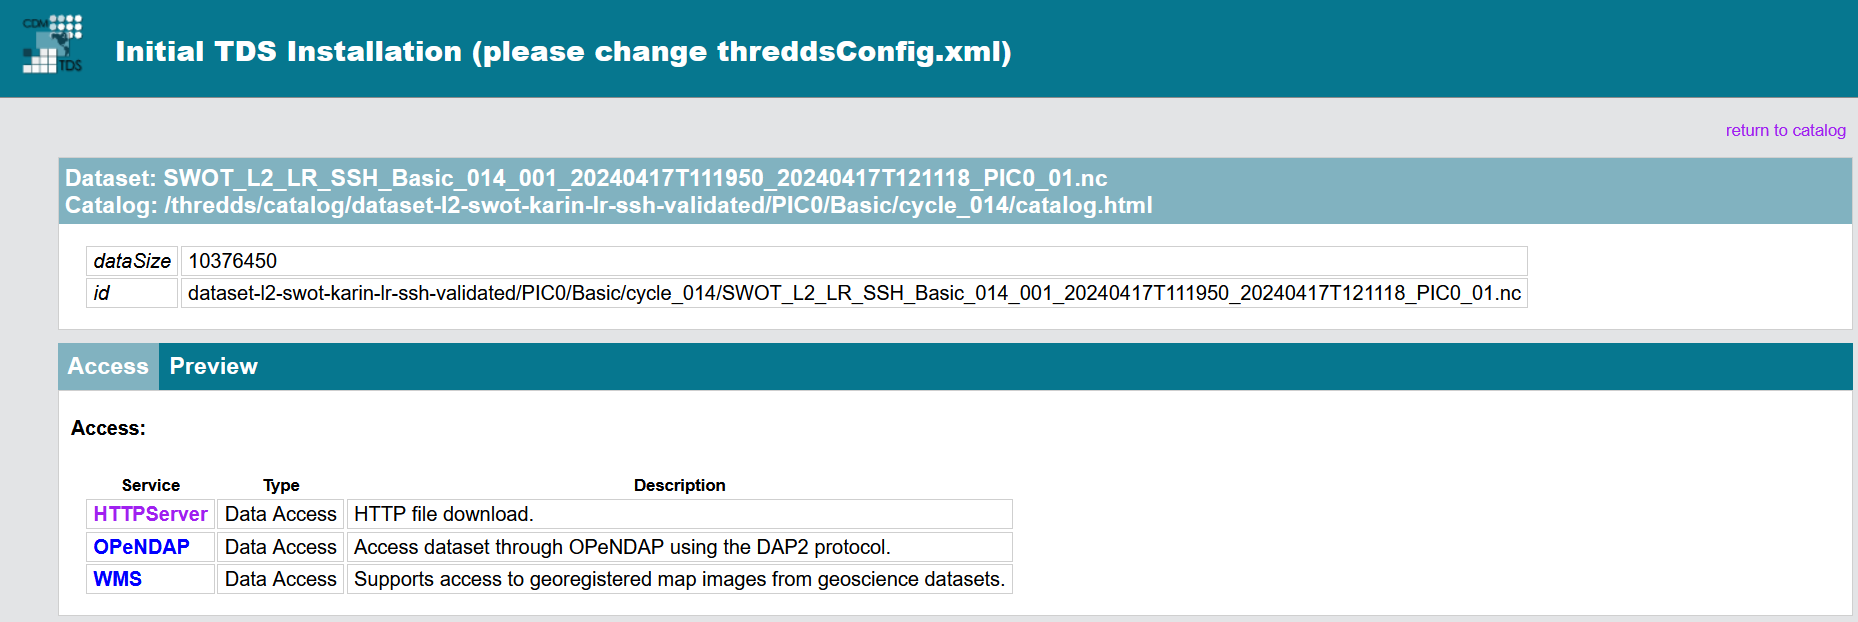

In [11]:
swot_lr_dataset_url = "https://tds-odatis.aviso.altimetry.fr/thredds/dodsC/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v1_0_2/Basic/cycle_014/SWOT_L3_LR_SSH_Basic_014_001_20240417T111950_20240417T121116_v1.0.2.nc"

In [12]:
swot_lr_dataset = open_dataset(swot_lr_dataset_url)
swot_lr_dataset

<xarray.Dataset> Size: 27MB
Dimensions:         (num_lines: 9860, num_pixels: 69, num_nadir: 1450)
Coordinates:
    latitude        (num_lines, num_pixels) float64 5MB ...
    longitude       (num_lines, num_pixels) float64 5MB ...
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables:
    time            (num_lines) datetime64[ns] 79kB ...
    mdt             (num_lines, num_pixels) float64 5MB ...
    ssha            (num_lines, num_pixels) float64 5MB ...
    ssha_noiseless  (num_lines, num_pixels) float64 5MB ...
    i_num_line      (num_nadir) int16 3kB ...
    i_num_pixel     (num_nadir) int8 1kB ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    geospatial_lat_units:            degrees_north
    ...                              ...
    geospatial_lon_max:              359.999986
    date_modified:                   2024-08-07T12:52:54Z
    history:                         2024-08-07T12:52:54Z: Created by DUACS K...
    date_created:                    2024-08-07T12:52:54Z
    date_issued:                     2024-08-07T12:52:54Z
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0 (NASA/CNE...

### Select variables



In [13]:
variables = ['time', 'ssha']

In [14]:
ds = swot_lr_dataset[variables]
ds

<xarray.Dataset> Size: 16MB
Dimensions:    (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude   (num_lines, num_pixels) float64 5MB ...
    longitude  (num_lines, num_pixels) float64 5MB ...
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time       (num_lines) datetime64[ns] 79kB ...
    ssha       (num_lines, num_pixels) float64 5MB ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    geospatial_lat_units:            degrees_north
    ...                              ...
    geospatial_lon_max:              359.999986
    date_modified:                   2024-08-07T12:52:54Z
    history:                         2024-08-07T12:52:54Z: Created by DUACS K...
    date_created:                    2024-08-07T12:52:54Z
    date_issued:                     2024-08-07T12:52:54Z
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0 (NASA/CNE...

### Select lines
Select lines to load



In [15]:
idx_first, idx_last = 5000, 6000

In [16]:
ds = xr.merge([ds[var][idx_first:idx_last] for var in variables])

In [17]:
ds.load()

<xarray.Dataset> Size: 2MB
Dimensions:    (num_lines: 1000, num_pixels: 69)
Coordinates:
    latitude   (num_lines, num_pixels) float64 552kB 1.333 1.33 ... 19.0 19.0
    longitude  (num_lines, num_pixels) float64 552kB 359.7 359.8 ... 3.734 3.753
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time       (num_lines) datetime64[ns] 8kB 2024-04-17T11:45:58.011918720 ....
    ssha       (num_lines, num_pixels) float64 552kB nan nan nan ... nan nan nan
Attributes:
    comment:             Time of measurement in seconds in the UTC time scale...
    leap_second:         0000-00-00T00:00:00Z
    long_name:           time in UTC
    standard_name:       time
    tai_utc_difference:  37.0
    _ChunkSizes:         9860

### Store the dataset to a NetCDF file



In [18]:
# Set encoding for each variable
for var in list(ds.keys()):
    ds[var].encoding = {'zlib':True, 'complevel':5}